## Notebook for waveform generation

This notebook generates the waveform as per Appendix A requirement.


In [1]:
import platform
import numpy as np
import matplotlib.pyplot as plt
import sys
import hashlib
import scipy.signal as signal


First we print out relevant package version. This notebook has been run using [lusee/lusee-night-unity-luseepy:1.0](https://hub.docker.com/layers/lusee/lusee-night-unity-luseepy/1.0/images/sha256-a9fb9b47e1f300025995fc35c917ba865725285fa52a61c58920540a25439559?context=explore) Docker image. Stick to that for maximum compatibility. Run `ljupyter` as defined [here](https://github.com/lusee-night/luseepy/blob/main/setup_env.sh).

In [2]:
print ('Python version:', platform.python_version())
print ('Numpy version:', np.__version__)
try:
    assert(sys.byteorder=='little')
except:
    print ('Error: sys.byteorder is not little-endian')
    raise AssertionError

Python version: 3.10.1
Numpy version: 1.25.0


# Part 1: generating the waveform

Basic settings first:

In [3]:
# filenames
filename_root = 'waveforms/calibrator_231001'
filename = filename_root + '.bin'

# basic waveform parameters
N = 2048 # length of our waveform
sampling_rate = 102.4e6 # sampling rate of our waveform in Hz

# random number generator
seed = 20151023 # Brin's birthday
randint_check = 9291 # check value for random number generator for this seed
md5sum_check = 'b5f829b5e2dbef213030a1761fa85b62' # md5sum of the resulting file for this code / seed

In [4]:
# Check our seed is OK
np.random.seed(seed) # set the seed of the random number generator
try:
    assert(np.random.randint(10000)==randint_check)
except AssertionError:
    print ("The first random number given seed is not what we expect. Check your numpy version / python environment.")

Now we generate the waveform.

In [5]:
# Generate a random waveform with unity amplitude and random phase
Nfft = N//2+1 # number of frequency bins
wave_fourier = np.exp(1j*np.random.uniform(0,2*np.pi, Nfft)) # random phase complex plain
wave_fourier[::2] = 0 # set the DC component + all even to zero
wave_fourier[-1] = 0 # set the Nyquist component to zero
wave = np.fft.irfft(wave_fourier,N) # generate the waveform
Nh = N//2
try:
    # Since we killed all the even frequency components, the second half
    # is a repeat of the first with a negative sign, exactly 
    assert((wave[:Nh] - (-wave[Nh:]) == 0.0).all()) # check the waveform is real
except AssertionError:
    print ("The waveform does not obey the internal consistency! Something badly wrong")
    raise AssertionError

Now we demonstrate that the waveform does what it is suppossed to do.

In [6]:
def plot_repeated_spectrum(wave, Nrepeat = 100, Nplot_1 = 10):
    Nplot = Nplot_1*Nrepeat
    wave_long = np.tile(wave, Nrepeat) # repeat the waveform Nrepeat times
    spectrum = np.abs(np.fft.rfft(wave_long)**2) # compute the spectrum
    base_freq = sampling_rate/wave_long.size # In Hz,
    plt.figure(figsize=(10,3))
    plt.plot(np.arange(Nplot)*base_freq/1e3, spectrum[:Nplot])
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Power [arbitrary units]')

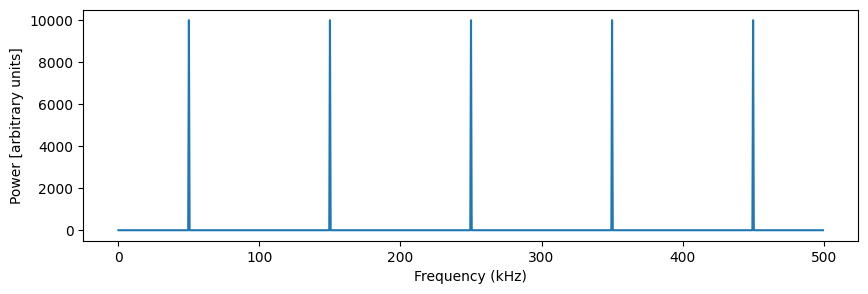

In [7]:
plot_repeated_spectrum(wave)

Next we need to convert to 16 bit signed and store


In [8]:
# renormalize the waveform to peak 16bit signed integer with some headroom
Amax = 2**15*0.99
wave_norm = wave/np.abs(wave).max()*Amax
wave16 = wave_norm.astype(np.int16) # convert to 16bit signed integer
Nw = open(filename,'wb').write(wave16.tobytes())
try:
    assert (Nw==N*2) # 2 bytes per sample
except AssertionError:
    print (f"Something went wrong writing the file. {Nw} bytes written, {2*N} bytes expected.")


In [9]:
md5sum = hashlib.md5(open(filename,'rb').read()).hexdigest()
try:
    assert(md5sum == md5sum_check)
except AssertionError:
    print (f"Something went wrong this time. md5sum is {md5sum}, expected {md5sum_check}.")
    raise AssertionError
print ('MD5sum OK, OCD in check.')

MD5sum OK, OCD in check.


# Part 2: Read and check

Text(0, 0.5, 'value')

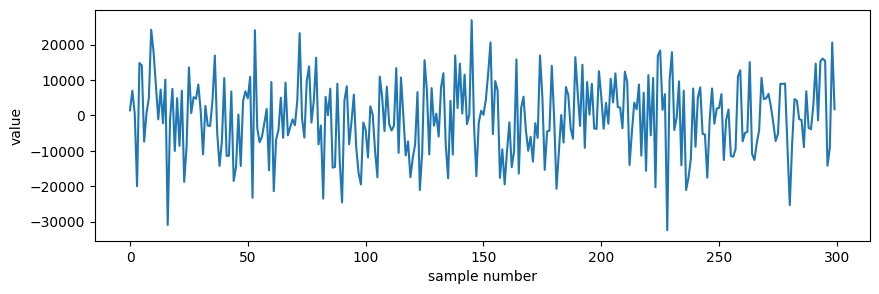

In [10]:
# Read file and plot 
wave = np.fromfile(filename, dtype=np.int16) # read the file
Nplot = 300
plt.figure (figsize=(10,3))
plt.plot(np.arange(Nplot), wave[:Nplot])
plt.xlabel('sample number')
plt.ylabel('value')


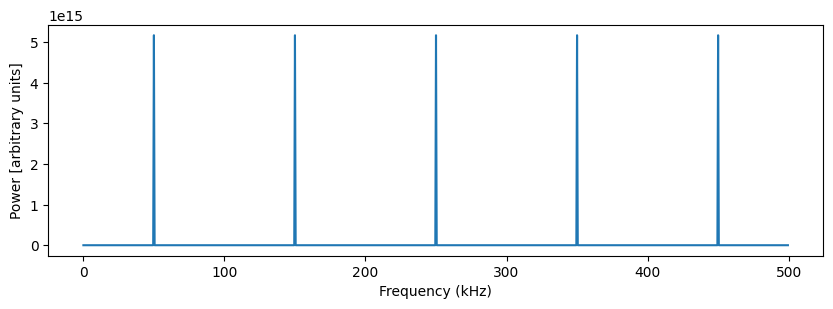

In [11]:
# and the power spectrum
plot_repeated_spectrum(wave)

# Part 3: Generate oversampled waveforms 
(with various assumptions about out out-of-band spectrum)

In [12]:
oversample = 16

# first normalizes to unit rms
wave_norm = wave / np.sqrt(wave.var())
# Back to FFT space, given the actual sampled waveformed
wave_fft = np.fft.rfft(wave_norm)
# band limited sample -- just pad with zeros
wave_os_band = np.fft.irfft(np.hstack((wave_fft,np.zeros(N*oversample//2+1-len(wave_fft),complex)))) * oversample
# nearest neighbor sample 
wave_os_step= np.array([wave_norm[int((i+oversample/2-1)/oversample)%N] for i in range(oversample*N)])
#
# low pass SOS filter with a cut-off at 60 MHz
sos = signal.butter(2, 60e6, 'low', fs=sampling_rate*oversample,output='sos')
# we stack three in a row, then take the middle third
wave_os_filt = signal.sosfilt(sos, np.tile(wave_os_step,3))[len(wave_os_step):2*len(wave_os_step)]


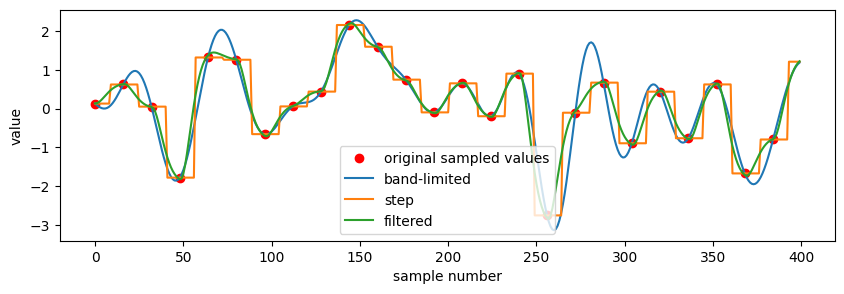

In [13]:
Nplot = (400//oversample) * oversample # round up to oversampling
Nofs = 8 # filtered signal need to be brought back in time to be aligned (it is a causal filter after all)
plt.figure (figsize=(10,3))
plt.plot(np.arange(Nplot//oversample)*oversample, wave_norm[:Nplot//oversample],'ro',label='original sampled values')
plt.plot(wave_os_band[:Nplot], label = 'band-limited')
plt.plot(wave_os_step[:Nplot], label = 'step')
plt.plot(wave_os_filt[Nofs:Nplot+Nofs], label = 'filtered')
plt.xlabel('sample number')
plt.ylabel('value')
plt.legend()

In [14]:
filename_os_root = filename_root + f'_x{oversample}'
np.savetxt(filename_os_root + '_bandlimited.dat', wave_os_band, fmt='%15.14g')
np.savetxt(filename_os_root + '_step.dat', wave_os_step, fmt='%15.14g')
np.savetxt(filename_os_root + '_filtered.dat', wave_os_filt, fmt='%15.14g')